**Note:** The following is code based (and sometimes modified) on the chapter from the book with any associated text paraphrased from the book's explanations.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_CSV = "housing.csv"

## Initial Data Exploration

In [2]:
# load dataset
def load_data(path, filename):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

housing = load_data(HOUSING_PATH, HOUSING_CSV)

In [3]:
housing.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20417,-118.86,34.19,29.0,1326.0,185.0,586.0,187.0,6.5474,422900.0,<1H OCEAN
10125,-117.91,33.94,15.0,5799.0,842.0,2314.0,787.0,6.3433,350500.0,<1H OCEAN
13463,-117.37,34.13,17.0,2681.0,470.0,1621.0,459.0,3.8750,118500.0,INLAND
10626,-117.77,33.71,13.0,1939.0,247.0,928.0,244.0,8.1111,379800.0,<1H OCEAN
3668,-118.39,34.23,18.0,3405.0,831.0,3001.0,795.0,3.0083,181900.0,<1H OCEAN


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

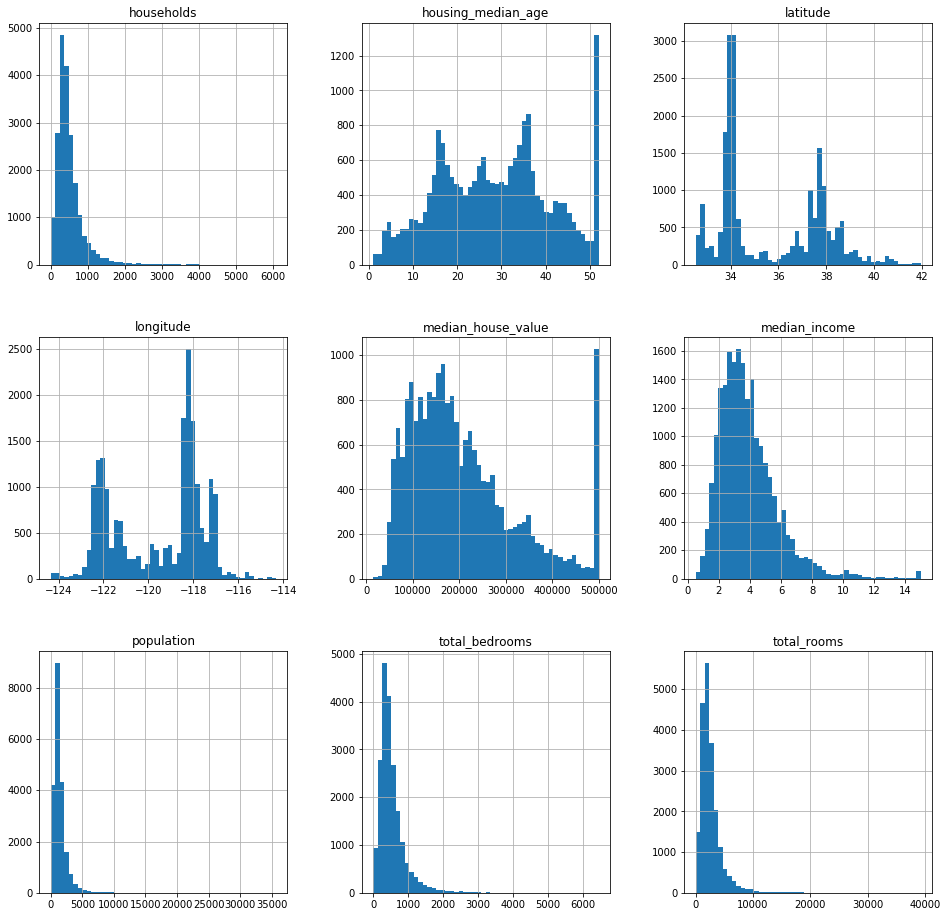

In [7]:
housing.hist(bins = 50, figsize=(16, 16))
plt.show()

Observations based on the above histograms:

- `median_income` does not seem to be expressed in USD. As per data source, numbers represent roughly tens of thousands of dollars. The data range has also been limited to about 0.5 to 15
- The `median_house_value` and `housing_median_age` data are also capped. Which could be a problem because those are our target variables as well, so, our model could end up learning that those values don't go beyond those capped values.
- Multiple of these are "tail heavy"

## Create Test Set

We will check out multiple approaches for creating a test set below. 

### Random split

In [8]:
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_idx = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_idx[:test_set_size]
    train_indices = shuffled_idx[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)

print(len(housing), len(train_set), len(test_set))

20640 16512 4128


### Instance Identifiers

Use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). 

For example, we could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset. 

The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Our housing dataset doesn't have an identifier column, so we can use the row index as the ID.

When using the row index as the ID, we need to make sure that 

- the new data is appended to the end of the dataset
- no row gets deleted

If the above is not possible, then some other stable feature can be considered as the ID. Like the `latitude` and `longitude` columns. However, it's important to note that many districts will end up with the same ID resulting in them ending up being in the same set. This would introduce some sampling bias.

In [11]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

### Using Scikit-Learn

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

The test set should be representative of the dataset and the target variables.

For example, let's say that the median income is an important target attribute to predict the median housing prices. We may want to ensure that the test set is representative of the different income categories in present in the dataset.

Since the median income is not a discrete attribute, we can create one for the income categories.

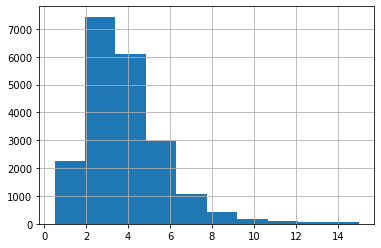

In [13]:
housing["median_income"].hist()

Most values are between 1.5 to 6, but some go beyond 6 as well. We will select 5 categories (0 to 6, 1.5 intervals) to have a balanced number of instances for each stratum

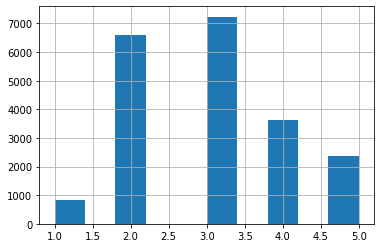

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                                  bins = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                  labels = [1, 2, 3, 4, 5])

housing["income_cat"].hist()

Based on the above we will carry out stratified sampling

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

In [16]:
# income category proportions in test set
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
# income category proportions in data
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

The above indicates that the test set does accurately represent the actual dataset. Let's compare the above to the random sampling code we wrote before

In [18]:
random_train_set, random_test_set = split_train_test(housing, 0.2)

random_test_set["income_cat"].value_counts()/len(random_test_set)

3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64

Randomg sampling does seem to produce slightly skewed results

In [19]:
# return data to original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## EDA

### Visualize Graphical Data

In [20]:
housing_train = strat_train_set.copy()

<Figure size 576x576 with 0 Axes>

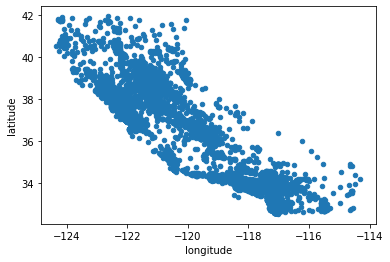

In [21]:
plt.figure(figsize=(8,8))
housing_train.plot(kind="scatter", x="longitude", y="latitude");

Let's focus on places with higher density of data

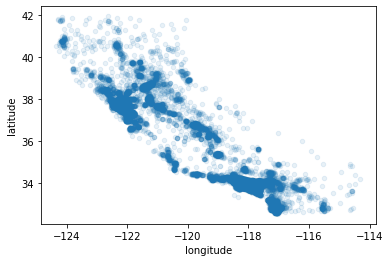

In [22]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

Now let's look into housing prices for these regions

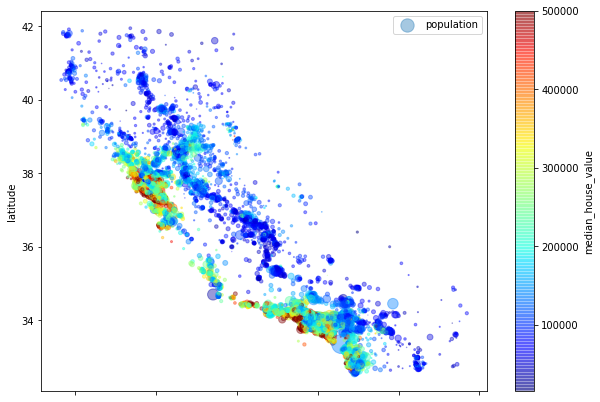

In [23]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", 
                   alpha=0.4, s=housing_train["population"]/100,
                   label="population", c="median_house_value",
                   figsize=(10,7),cmap=plt.get_cmap("jet"), colorbar=True);

plt.legend();

Based on the above two plots, we can see that the housing prices are related to the location and population density.

Next, let's find the correlation between the attributes and the median house value.

In [24]:
corr_matrix = housing_train.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

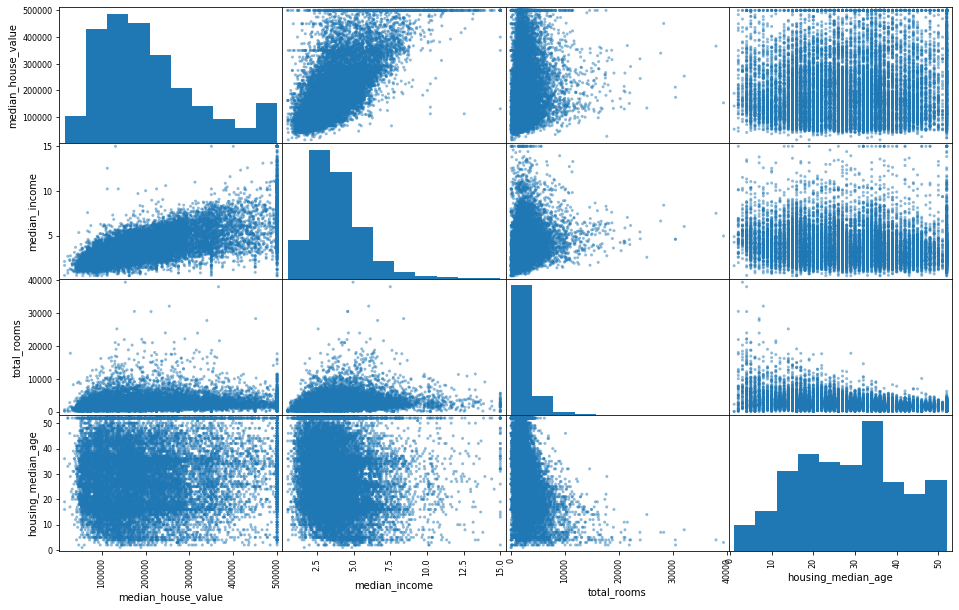

In [25]:
from pandas.plotting import scatter_matrix

attr = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing_train[attr], figsize=(16,10));

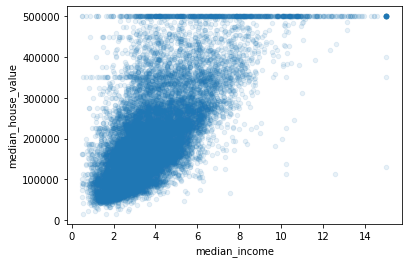

In [26]:
housing_train.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

Couple things to note here:

- There is a clear upward trend, and the points are not too dispersed indicating a strong correlation between the two
- The cap on the data is noticeable with the line of points at the 500000 mark.
- There are some other horizontal lines that are vaguely visible, like around the 350000 mark. It might make sense to consider removing such districts showing similar patterns to clean up the data.

### Experimenting with Attributes

Let's create some new attributes which make more sense to look into:

- rooms per household
- bedrooms per total number of rooms
- population per household

In [27]:
housing_train["rooms_per_household"] = housing_train["total_rooms"]/housing_train["households"]
housing_train["bedrooms_per_room"] = housing_train["total_bedrooms"]/housing_train["total_rooms"]
housing_train["population_per_household"] = housing_train["population"]/housing_train["households"]

In [28]:
corr_matrix = housing_train.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Observations based on the above:

- Houses with fewer bedrooms per total number of rooms tend to be more expensive
- Larger the houses (rooms per household), more expensive they are likely to be

## Data Preparation for ML

We will revert to the clean training set for this and also separate out the labels from the predictors.

In [29]:
housing_train = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

In [30]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


Since most ML algorithms can't work with missing data, we will have to handle them appropriately. Let's start with `total_bedrooms` as that is missing some values.

We will replace them with the median value of the column. We will also need this median value stored for later to replace missing values in the test set when we want to evaluate our system, and also once the system goes live to replace missing values in new data.

We will use Scikit-learn for handling this

In [31]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# temporarily disregard `ocean_proximity` since it's non-numeric
housing_num = housing_train.drop("ocean_proximity", axis=1)

# fit imputer
imputer.fit(housing_num)

print(imputer.statistics_)

# cross-check
print(housing_num.median())

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64


It's better (or safer) to apply the imputer to all numeric vvalues, because we won't know if we will have more missing values with new incoming data when system goes live

In [32]:
x = imputer.transform(housing_num)

### Handling Text/Categorical Attributes

Converting categories into numbers

In [33]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

housing_cat = housing_train[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]



array([[0.],
       [0.],
       [4.],
       [1.],
       [0.]])

In [34]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One possible problem with the above approach is that the ML algorithm will assume that 2 nearby values are more similar than 2 distant ones. Which works if we have ordered categories, but that's not the case here.

To fix this, another approach is to use one-hot encoding.

In [35]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a SciPy sparse matrix. It only stores the location of the non-zero elements

In [36]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformer

We will create a transformer class that adds the combined attributes we defined earlier.

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_idx, bedrooms_idx, population_idx, households_idx = 3, 4, 5, 6

class CombinedAtrributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_idx]/X[:, households_idx]
        population_per_household = X[:, population_idx]/X[:, households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx]/X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

attr_adder = CombinedAtrributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_train.values)

`add_bedrooms_per_room` is a hyperparameter that will allow us to easily find out whether adding that attribute helps the ML algorithm or not.

### Transformation Pipelines

We will convert the above sequence of steps/transformations into a pipeline. We will also scale the features of our data in this pipeline

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("attribs_adder", CombinedAtrributesAdder()),
                ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

It might be better to apply the appropriate transformations to all columns

In [39]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", OneHotEncoder(), cat_attribs)
                ])

housing_prepared = full_pipeline.fit_transform(housing_train)

In [40]:
print(housing_prepared)
print(housing_prepared.shape)

[[-1.15604281  0.77194962  0.74333089 ...  0.          0.
   0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...  0.          0.
   0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...  0.          0.
   1.        ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.          0.
   0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.          0.
   0.        ]
 [-1.43579109  0.99645926  1.85670895 ...  0.          1.
   0.        ]]
(16512, 16)


`ColumnTransformer` applies each transformer to the corresponding columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

The `OneHotEncoder()` returns a Sparse Matrix, while the `num_pipeline` returns a Dense Matrix. In this case, `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of non-zero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3).

## Select and Train a Model

### Linear Regression
Let's start with a Linear Regression model

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We will try the model out on a small sample from the training set

In [42]:
some_data = housing_train.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Based on the above, let's measure the RMSE

In [43]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848923


Most districts' `median_house_value` ranged between $120,000 and $265,000. So, an error of about $68628 isn't that great. The model is likely underfitting, since the features are not providing enough information to be able to make good predictions.

We will try a more powerful model to try and see if we can improve upon this.

### Decision Tree Regressor

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [45]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


That's...that's not right.

Either the model is perfect, or it has badly overfit the data, or worse. We will use validation sets now to look into this.

### Cross-Validation

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

Note: Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value).

In [47]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_scores(tree_rmse_scores)

Scores:  [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean:  70666.74616904806
Standard deviation:  2928.322738055112


The model's perfofrming worse than before. Let's do the same for the Linear Regression model as well.

In [48]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.674001798349


### Random Forest Regressor

The Decision Tree model is overfitting so much that it is performing worse than the Linear Regression model. We'll next try the `Random Forest Regressor` as well.

In [49]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print("Forest RMSE: ", forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

C:\Users\Sahil\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Forest RMSE:  22256.354579885898
Scores:  [52868.21871547 49194.92340594 51713.77716246 55012.10310441
 50973.88861214 55990.4479905  52298.68285092 50953.09058463
 54428.48087563 53461.73225682]
Mean:  52689.53455589254
Standard deviation:  1980.36257012708


There's improvement!

But the training error score is still lower than the validation set. That still indicated overfitting.

## Fine-Tune the Model

### Grid Search

Instead of manually tweaking the hyperparameters to fine-tune our model, we can use Grid Search. Based on our selectetd hyperparameters, Grid Search will evaluate all the possible combinations of hyperparameter values,
using cross-validation.

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = [
            {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
            {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
             ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = "neg_mean_squared_error",
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


`param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of `n_estimators` and `max_features` hyperparameter values specified in the first dict, then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, but this time with the `bootstrap` hyperparameter set to False instead of True.

All in all, the grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and it will train each model five times. That's a total of 90 rounds of training.

In [51]:
# best combination of hyperparameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [52]:
# best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [53]:
# evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64560.56453532923 {'max_features': 2, 'n_estimators': 3}
55582.7022830937 {'max_features': 2, 'n_estimators': 10}
52946.41821544518 {'max_features': 2, 'n_estimators': 30}
60706.36585084631 {'max_features': 4, 'n_estimators': 3}
52620.50721816631 {'max_features': 4, 'n_estimators': 10}
50524.81738581646 {'max_features': 4, 'n_estimators': 30}
58527.66047437809 {'max_features': 6, 'n_estimators': 3}
52222.271025610295 {'max_features': 6, 'n_estimators': 10}
49935.06005093446 {'max_features': 6, 'n_estimators': 30}
58659.80511658877 {'max_features': 8, 'n_estimators': 3}
52363.81008209303 {'max_features': 8, 'n_estimators': 10}
50107.93319293479 {'max_features': 8, 'n_estimators': 30}
62413.99504781873 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54498.69196389087 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60335.933168485164 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52359.94950597992 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

As we can see from the above, 6 for `max_features`, and 30 for `n_estimators` produces the lowest score. This is better than the score we got earlier with default hyperparameters.